<a href="https://colab.research.google.com/github/chdb-io/chdb/blob/main/examples/chDB_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pandas pyarrow --upgrade
!pip install chdb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 9.0.0
    Uninstalling pyarrow-9.0.0:
      Successfully uninstalled pyarrow-9.0.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 12.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 MB 4.3 MB/s eta 0:00:0

GitHub: https://github.com/chdb-io/chdb

# Query on S3/HTTP/File/Another ClickHouse

   RegionID  sum(AdvEngineID)       c  avg(ResolutionWidth)  uniqExact(UserID)
0       229             38044  426435           1612.787187              27961
1         2             12801  148193           1593.870891              10413
2       208              2673   30614           1490.615111               3073
3         1              1802   28577           1623.851699               1720
4        34               508   14329           1592.897201               1428
5        47              1041   13661           1637.851914                943
6       158                78   13294           1576.340605               1110
7         7              1166   11679           1627.319034                647
8        42               642   11547           1625.601022                956
9       184                30   10157           1614.693807                987


<Axes: >

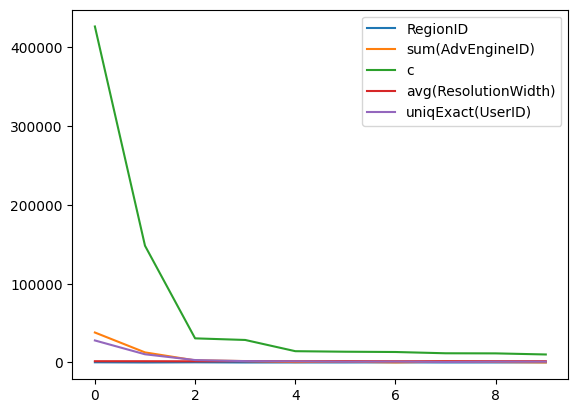

In [4]:

# Run chDB on HTTP (Parquet, CSV, JSON ...)
!wget 'https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet' -q -O hits_0.parquet
import chdb

data = "url('https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet')"
# data = "file('hits_0.parquet', Parquet)"
# data = "s3('xxx')"
# data = ""

sql = f"""SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID)
                        FROM {data} GROUP BY RegionID ORDER BY c DESC LIMIT 10"""
ret = chdb.query(sql, 'dataframe')
print(ret)
ret.plot()

                          repo  stars
0         b'karpathy/llama2.c'   2400
1          b'jmorganca/ollama'    826
2    b'facebookresearch/llama'    732
3         b'FuelLabs/fuels-rs'    677
4         b'FuelLabs/fuels-ts'    664
5  b'SebLague/Chess-Challenge'    663
6        b'microsoft/TypeChat'    618
7   b'Lxtharia/minegrub-theme'    607
8        b'FuelLabs/fuel-core'    607
9           b'base-org/chains'    574


<Axes: ylabel='repo'>

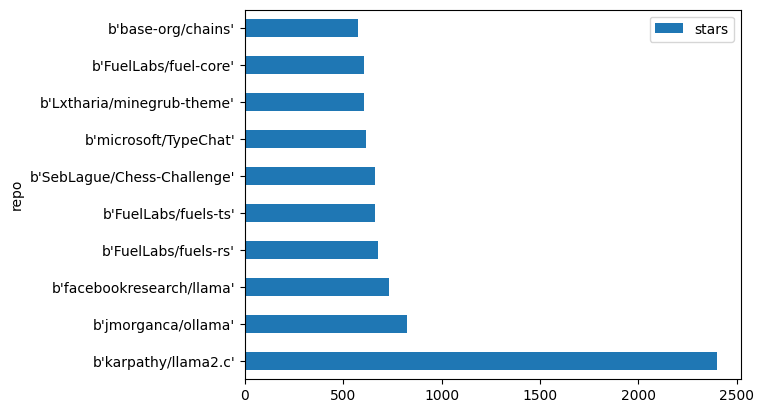

In [15]:
# Query another ClickHouse server
ret = chdb.query("""SELECT
    repo_name AS repo,
    count() AS stars
FROM remoteSecure('play.clickhouse.com', default, github_events, 'play', 'play')
WHERE event_type = 'WatchEvent' AND created_at > today() -1
GROUP BY repo_name
ORDER BY stars DESC
LIMIT 10""", "dataframe")
print(ret)
ret.plot(x='repo', kind='barh')

# With pandas.Dataframe

In [ ]:
# Run on pandas.Dataframe and output Dataframe
import chdb.dataframe as cdf
import pandas as pd

tbl = cdf.Table(dataframe=pd.DataFrame({'i':[1,2,3,4],'j':["one", "two", "three", "four"]}))

ret_tbl = tbl.query('SELECT * FROM __table__')

## Query on result table
ret_tbl.query('SELECT i, i*2, j FROM __table__ ORDER BY i desc')
ret_tbl.

   i  multiply(i, 2)         j
0  4               8   b'four'
1  3               6  b'three'
2  2               4    b'two'
3  1               2    b'one'

# With session(Beta)

Select from view:

┏━━━┳━━━┓
┃ x ┃ y ┃
┡━━━╇━━━┩
│ a │ 1 │
├───┼───┤
│ b │ 3 │
├───┼───┤
│ c │ 2 │
├───┼───┤
│ d │ 5 │
└───┴───┘



<Axes: >

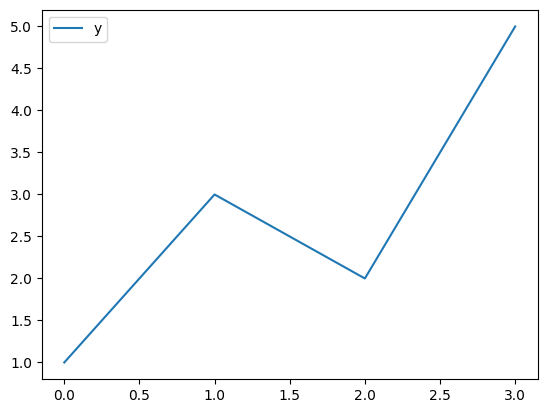

In [ ]:
# Run chDB with session

from chdb import session as chs

## Create DB, Table, View in temp session, auto cleanup when session is deleted.
sess = chs.Session()
sess.query("CREATE DATABASE IF NOT EXISTS db_xxx ENGINE = Atomic")
sess.query("CREATE TABLE IF NOT EXISTS db_xxx.log_table_xxx (x String, y Int) ENGINE = Log;")
sess.query("INSERT INTO db_xxx.log_table_xxx VALUES ('a', 1), ('b', 3), ('c', 2), ('d', 5);")
sess.query(
    "CREATE VIEW db_xxx.view_xxx AS SELECT * FROM db_xxx.log_table_xxx LIMIT 4;"
)
print("Select from view:\n")
print(sess.query("SELECT * FROM db_xxx.view_xxx", "Pretty"))

sess.query("SELECT * FROM db_xxx.view_xxx", "dataframe").plot()

In [ ]:
## Keep session data in a dir
sess2 = chs.Session("ch_session")
sess2.query("CREATE FUNCTION chdb_version AS () -> '0.11.3'")
print("UDF chdb_version:", sess2.query("SELECT chdb_version()", "CSV"))

print("Content of dir ch_session:")
!ls -l ch_session

## Named session need cleanup,
sess2.cleanup()


UDF chdb_version: "0.11.3"

Content of dir ch_session:
total 24
drwxr-xr-x 3 root root 4096 Jul 24 04:10 data
drwxr-xr-x 4 root root 4096 Jul 24 04:10 metadata
drwxr-xr-x 2 root root 4096 Jul 24 04:10 metadata_dropped
drwxr-xr-x 3 root root 4096 Jul 24 04:10 store
drwxr-xr-x 2 root root 4096 Jul 24 04:10 tmp
drwxr-xr-x 2 root root 4096 Jul 24 04:10 user_defined
